# Visualizing Gradients

This tutorial explains how to extract and visualize gradients at any layer in a neural network. By inspecting how information flows from the end of the network to the parameters we want to optimize, we can debug issues such as vanishing or exploding gradients that occur during training.

Before starting, make sure you understand tensors and how to manipulate them. A basic knowledge of how autograd works would also be useful.

## setup 

First, make sure PyTorch is installed and then import the necessary libraries.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

Next, we’ll be creating a network intended for the MNIST dataset, similar to the architecture described by the batch normalization paper.

To illustrate the importance of gradient visualization, we will instantiate one version of the network with batch normalization (BatchNorm), and one without it. Batch normalization is an extremely effective technique to resolve vanishing/exploding gradients, and we will be verifying that experimentally.

The model we use has a configurable number of repeating fully-connected layers which alternate between nn.Linear, norm_layer, and nn.Sigmoid. If batch normalization is enabled, then norm_layer will use BatchNorm1d, otherwise it will use the Identity transformation.

In [2]:
def fc_layer(in_size, out_size, norm_layer):
    """Return a stack of linear->norm->sigmoid layers"""
    return nn.Sequential(nn.Linear(in_size, out_size), norm_layer(out_size), nn.Sigmoid())

class Net(nn.Module):
    """Define a network that has num_layers of linear->norm->sigmoid transformations"""
    def __init__(self, in_size=28*28, hidden_size=128,
                 out_size=10, num_layers=3, batchnorm=False):
        super().__init__()
        if batchnorm is False:
            norm_layer = nn.Identity
        else:
            norm_layer = nn.BatchNorm1d

        layers = []
        layers.append(fc_layer(in_size, hidden_size, norm_layer))

        for i in range(num_layers-1):
            layers.append(fc_layer(hidden_size, hidden_size, norm_layer))

        layers.append(nn.Linear(hidden_size, out_size))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.layers(x)

Next we set up some dummy data, instantiate two versions of the model, and initialize the optimizers.

In [3]:
# set up dummy data
x = torch.randn(10, 28, 28)
y = torch.randint(10, (10, ))

# init model
model_bn = Net(batchnorm=True, num_layers=3)
model_nobn = Net(batchnorm=False, num_layers=3)

model_bn.train()
model_nobn.train()

optimizer_bn = optim.SGD(model_bn.parameters(), lr=0.01, momentum=0.9)
optimizer_nobn = optim.SGD(model_nobn.parameters(), lr=0.01, momentum=0.9)

We can verify that batch normalization is only being applied to one of the models by probing one of the internal layers:

In [4]:
print(model_bn.layers[0])
print(model_nobn.layers[0])

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Sigmoid()
)
Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): Identity()
  (2): Sigmoid()
)


## Registering hooks

Because we wrapped up the logic and state of our model in a nn.Module, we need another method to access the intermediate gradients if we want to avoid modifying the module code directly. This is done by registering a hook.

Warning

Using backward pass hooks attached to output tensors is preferred over using retain_grad() on the tensors themselves. An alternative method is to directly attach module hooks (e.g. register_full_backward_hook()) so long as the nn.Module instance does not do perform any in-place operations. For more information, please refer to this issue. https://github.com/pytorch/pytorch/issues/61519

The following code defines our hooks and gathers descriptive names for the network’s layers.


In [5]:
# note that wrapper functions are used for Python closure
# so that we can pass arguments.

def hook_forward(module_name, grads, hook_backward):
    def hook(module, args, output):
        """Forward pass hook which attaches backward pass hooks to intermediate tensors"""
        output.register_hook(hook_backward(module_name, grads))
    return hook

def hook_backward(module_name, grads):
    def hook(grad):
        """Backward pass hook which appends gradients"""
        grads.append((module_name, grad))
    return hook

def get_all_layers(model, hook_forward, hook_backward):
    """Register forward pass hook (which registers a backward hook) to model outputs

    Returns:
        - layers: a dict with keys as layer/module and values as layer/module names
                  e.g. layers[nn.Conv2d] = layer1.0.conv1
        - grads: a list of tuples with module name and tensor output gradient
                 e.g. grads[0] == (layer1.0.conv1, tensor.Torch(...))
    """
    layers = dict()
    grads = []
    for name, layer in model.named_modules():
        # skip Sequential and/or wrapper modules
        if any(layer.children()) is False:
            layers[layer] = name
            layer.register_forward_hook(hook_forward(name, grads, hook_backward))
    return layers, grads

# register hooks
layers_bn, grads_bn = get_all_layers(model_bn, hook_forward, hook_backward)
layers_nobn, grads_nobn = get_all_layers(model_nobn, hook_forward, hook_backward)

## Training and visualization

Let’s now train the models for a few epochs:

In [6]:
epochs = 10

for epoch in range(epochs):

    # important to clear, because we append to
    # outputs everytime we do a forward pass
    grads_bn.clear()
    grads_nobn.clear()

    optimizer_bn.zero_grad()
    optimizer_nobn.zero_grad()

    y_pred_bn = model_bn(x)
    y_pred_nobn = model_nobn(x)

    loss_bn = F.cross_entropy(y_pred_bn, y)
    loss_nobn = F.cross_entropy(y_pred_nobn, y)

    loss_bn.backward()
    loss_nobn.backward()

    optimizer_bn.step()
    optimizer_nobn.step()

After running the forward and backward pass, the gradients for all the intermediate tensors should be present in grads_bn and grads_nobn. We compute the mean absolute value of each gradient matrix so that we can compare the two models.

In [7]:
def get_grads(grads):
    layer_idx = []
    avg_grads = []
    for idx, (name, grad) in enumerate(grads):
        if grad is not None:
            avg_grad = grad.abs().mean()
            avg_grads.append(avg_grad)
            # idx is backwards since we appended in backward pass
            layer_idx.append(len(grads) - 1 - idx)
    return layer_idx, avg_grads

layer_idx_bn, avg_grads_bn = get_grads(grads_bn)
layer_idx_nobn, avg_grads_nobn = get_grads(grads_nobn)


With the average gradients computed, we can now plot them and see how the values change as a function of the network depth. Notice that when we don’t apply batch normalization, the gradient values in the intermediate layers fall to zero very quickly. The batch normalization model, however, maintains non-zero gradients in its intermediate layers.



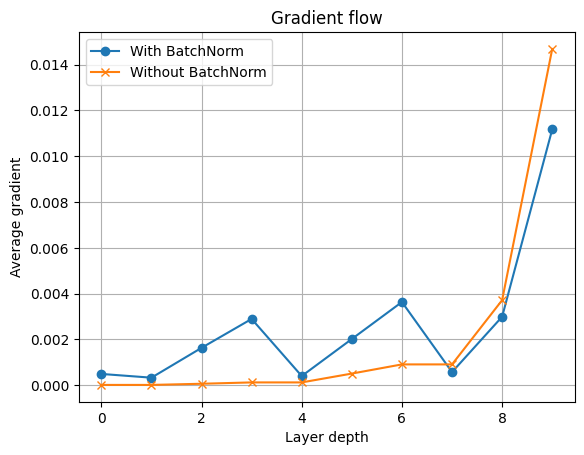

In [8]:
fig, ax = plt.subplots()
ax.plot(layer_idx_bn, avg_grads_bn, label="With BatchNorm", marker="o")
ax.plot(layer_idx_nobn, avg_grads_nobn, label="Without BatchNorm", marker="x")
ax.set_xlabel("Layer depth")
ax.set_ylabel("Average gradient")
ax.set_title("Gradient flow")
ax.grid(True)
ax.legend()
plt.show()

## Conclusion 

Conclusion
In this tutorial, we demonstrated how to visualize the gradient flow through a neural network wrapped in a nn.Module class. We qualitatively showed how batch normalization helps to alleviate the vanishing gradient issue which occurs with deep neural networks.

If you would like to learn more about how PyTorch’s autograd system works, please visit the references below. If you have any feedback for this tutorial (improvements, typo fixes, etc.) then please use the PyTorch Forums and/or the issue tracker to reach out.